* Reference: __Pairs Trading: Performance of a Relative Value Arbitrage Rule__ _by_ Gatev et al.

# Distance Approach

This description of the distance approach closely follows the paper by _Gatev, E., Goetzmann, W. N.,_ and _Rouwenhorst, K. G._ __Pairs Trading: Performance of a Relative Value Arbitrage Rule__  [available here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=141615). 

## Introduction

The distance approach works as follows:
- First, a historical period is defined, cumulative returns for assets in this period are normalized.
- Second, using the Euclidean squared distance on the normalized price time series, $n$ closest pairs of assets are picked.
- After the pairs are formed, the trading period starts, and the trading signals are generated. The mechanism
  behind this process if the following:
  - If the difference between the price of elements in a pair diverged by
    more than 2 standard deviations (calculated for each pair during the training period), the positions are
    opened - long for the element with a lower price in a portfolio and short for an element with a higher price
    in a portfolio.
  - These positions are closed when the normalized prices cross or when the trading period ends.

Using this standard description, the distance approach is a parameter-free strategy.

**Note:** No cointegration tests (as opposed to the mean reversion approach) are being performed in the distance
approach. As spotted in the work by Krauss (2015), dependencies found using this approach can be spurious.
This also leads to higher divergence risks, and as shown in the work by Do and Faff (2010), up to 32% of
pairs identified by this method are not converging.

There are, however, possible adjustments to this strategy, like choosing distances other from the Euclidean
square distance, adjusting the threshold to enter a trade for each pair, etc. 

## Pairs formation step

This stage of the DistanceStrategy consists of the following steps:

1. **Normalization of the input data.**

To use the Euclidean square distance, the training price time series are being normalized using the following
formula:

$$P_{normalized} = \frac{P - min(P)}{max(P) - min(P)}$$

where $P$ is the training price series of an asset, $min(P)$ and $max(P)$ are the minimum and maximum values from the price series.

2. **Finding pairs.**

Using the normalized price series, the distances between each pair of assets are calculated. These
distances are then sorted in the ascending order and the :math:`n` closest pairs are picked (our
function also allows skipping a number of first pairs, so one can choose pairs 10-15 to study).

The distances between elements (Euclidean square distance - SSD) are calculated as:

$$SSD = \sum^{N}_{t=1} (P^1_t - P^2_t)^{2}$$

where $P^1_t$ and $P^2_t$ are normalized prices at time $t$ for the first and
the second elements in a pair.

Using the prices of elements in a pair a portfolio is being constructed - the difference between
their normalized prices.

3. **Calculating historical volatility.**

For $n$ portfolios (differences between normalized price series of elements) calculated in the
previous step, their volatility is being calculated. Historical standard deviations of these portfolios
will later be used to generate trading signals.

## Trading signals generation


After pairs were formed, we can proceed to the second stage of the DistanceStrategy - trading
signals generation. The input to this stage is a dataframe with testing price series for assets - not
used in the pairs formation stage.

This stage of the DistanceStrategy consists of the following steps:

1. **Normalization of the input data.**

Using the same approach as in the pairs formation stage, we normalize the input trading dataset using
the same maximum and minimum historical values from the training price series.

2. **Portfolios creation.**

In this step, the portfolios are being constructed based on the asset pairs chosen in the pairs
formation step. Portfolio values series are differences between normalized price series of elements
in a pair - as we're opening a long position for the first element in a pair and a short position for
the second element in a pair. A buy signal generated by the strategy means going long on the first
element and short on the second. A sell signal means the opposite - going short on the first element
and long on the second element.

3. **Generating signals.**

If the portfolio value exceeds two historical deviations, a sell signal is generated - we expect
the price of the first element to decrease and the price of the second element to increase. And if
the value of the portfolio is below minus two historical deviations, a buy signal is generated.

An open position is closed when the portfolio value crosses the zero mark - or when the prices of
elements in a pair cross. So at any given time, we have one (buy or sell) or none active positions
opened. This makes cost allocation for the strategy easier. Resulting trading signals are target
quantities of portfolios to hold for each pair (with values -1, 0, or +1).

## Results output and plotting

The DistanceStrategy class contains multiple methods to get results in the desired form.

Functions that can be used to get data:

- **get_signals()** outputs generated trading signals for each pair.

- **get_portfolios()** outputs values series of each pair portfolios.

- **get_scaling_parameters()** outputs scaling parameters from the training dataset used to normalize data.

- **get_pairs()** outputs a list of tuples, containing chosen top pairs in the pairs formation step.

Functions that can be used to plot data:

- **plot_pair()** plots normalized price series for elements in a given pair and the corresponding
  trading signals for portfolio of these elements.

- **plot_portfolio()** plots portfolio value for a given pair and the corresponding trading signals.

## Usage of the Algorithms

Let's use the above strategy on real data. 

First, we will choose a training period of 12 months to form pairs. Second, we'll create trading signals for the following 6 months window. Finally, we will analyze the obtained results. 

In [1]:
import arbitragelab as al
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

### Loading data

As a dataset we'll download price time series for 176 stocks over a period from 01.2018 to 07.2019. First 12 months of data will be used for training and the following 6 months for trading signal generation and analysis of results. 

In [2]:
# List of tickers to use in the analysis
tickers = ['MMM', 'ABT', 'ANF', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD',
           'AKAM', 'AA', 'ALXN', 'ATI', 'ALL', 'MO', 'AMZN', 'AEE',
           'AEP', 'AXP', 'AIG', 'AMT', 'AMP', 'ABC', 'AMGN', 'APH', 'ADI', 'AON',
           'APA', 'AIV', 'AAPL', 'AMAT', 'ADM', 'AIZ', 'T', 'ADSK', 'ADP', 'AN',
           'AZO', 'AVB', 'AVY', 'BLL', 'BAC', 'BK', 'BAX', 'BDX', 'BBBY', 'BIG',
           'BIIB', 'BLK', 'HRB', 'BA', 'BWA', 'BXP', 'BSX', 'BMY', 'CHRW', 'COG',
           'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CAT', 'CNP', 'CERN', 'CF', 'SCHW',
           'CVX', 'CMG', 'CB', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CTXS', 'CLF',
           'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP',
           'CNX', 'ED', 'STZ', 'GLW', 'COST', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI',
           'DHR', 'DRI', 'DVA', 'DE', 'XRAY', 'DVN', 'DFS', 'DISCA',
           'DLTR', 'D', 'RRD', 'DOV', 'DTE', 'DD', 'DUK', 'ETFC', 'EMN',
           'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMR', 'ETR', 'EOG', 'EQT',
           'EFX', 'EQR', 'EL', 'EXC', 'EXPE', 'EXPD', 'XOM', 'FFIV', 'FAST', 'FDX',
           'FIS', 'FITB', 'FHN', 'FSLR', 'FE', 'FISV', 'FLIR', 'FLS', 'FLR', 'FMC',
           'FTI', 'F', 'FOSL', 'BEN', 'FCX', 'GME', 'GPS', 'GD', 'GE', 'GIS',
           'GPC', 'GNW', 'GILD', 'GS', 'GT', 'GOOG', 'GWW', 'HAL', 'HOG', 'HIG',
           'HAS', 'HP', 'HES', 'HPQ', 'HD', 'HON', 'HRL', 'HST', 'HUM', 'HBAN',
           'ITW']

# Loading data
train_data =  yf.download(tickers, start="2018-01-03", end="2019-01-01")
test_data =  yf.download(tickers, start="2019-01-02", end="2019-07-01")

# Taking close prices for chosen instruments
train_data = train_data["Adj Close"]
test_data = test_data["Adj Close"]

# Looking at the downloaded data
train_data.head()

[*********************100%***********************]  176 of 176 completed
[*********************100%***********************]  176 of 176 completed


,A,AA,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,...,KMX,KO,MMM,MO,RRD,SCHW,STZ,T,XOM,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.985886,55.169998,41.105534,89.101776,55.908627,146.872910,177.699997,85.325447,36.375210,109.238663,...,64.760002,41.253933,214.096344,58.734520,8.693686,49.142529,216.491425,32.041576,72.152405,65.617424
2018-01-03,67.664825,54.500000,41.098373,89.433365,56.032253,147.550751,181.039993,86.383995,36.093937,110.425331,...,66.940002,41.163342,214.087234,58.518658,8.377388,49.218956,217.389648,31.301641,73.569473,65.392639
2018-01-04,67.157242,54.700001,41.289268,89.234398,55.937157,149.297852,183.220001,86.289490,36.701855,111.480156,...,68.250000,41.743107,216.885666,58.286175,8.531018,49.496006,215.755630,31.592627,73.671303,65.382851
2018-01-05,68.230972,54.090000,41.759361,90.314545,56.098827,150.529449,185.339996,86.639168,36.456879,111.414223,...,71.040001,41.734043,218.575592,58.452229,8.576202,49.687077,210.108292,31.709024,73.611900,66.301537
2018-01-08,68.377396,55.000000,41.604263,91.811577,55.937157,151.732376,185.039993,86.790382,36.375210,111.075172,...,70.050003,41.670639,217.866882,58.377499,8.594278,49.906803,207.203400,31.800476,73.942833,66.751122


### Forming pairs

Now let's form pairs and calculate historical volatilities for chosen portfolio pairs based on training data.

In [3]:
# Initialising an object containing needed methods
strategy = al.distance_approach.DistanceStrategy()

# Performing the pairs formation step and picking top 20 pairs
strategy.form_pairs(train_data, num_top=20)

# Getting scaling values used to normalize data, a list of created pairs and historical volatility for each chosen pair portfolio
scaling_parameters = strategy.get_scaling_parameters()
pairs = strategy.get_pairs()
historical_std = strategy.train_std

In [4]:
# Looking at the scaling parameters 
scaling_parameters

,min_value,max_value
A,59.813347,73.381203
AA,25.150000,60.230000
AAPL,35.563320,56.013641
ABC,68.204529,99.941025
ABT,53.768047,71.924355
...,...,...
SCHW,36.961742,57.135441
STZ,151.924896,224.355804
T,24.092373,32.988255
XOM,57.892380,75.761978


These scaling parameters can be used to calculate weights for elements when creating a portfolio.

For example, if we have a pair portfolio of ('A', 'AA'), we can construct series of their normalized prices as:

In [5]:
# Normalizing the price series on our own (already done inside the DistanceStrategy class)
A_series_scaled = (train_data['A'] - scaling_parameters['min_value']['A']) / \
                  (scaling_parameters['max_value']['A'] - scaling_parameters['min_value']['A'])

AA_series_scaled = (train_data['AA'] - scaling_parameters['min_value']['AA']) / \
                   (scaling_parameters['max_value']['AA'] - scaling_parameters['min_value']['AA'])

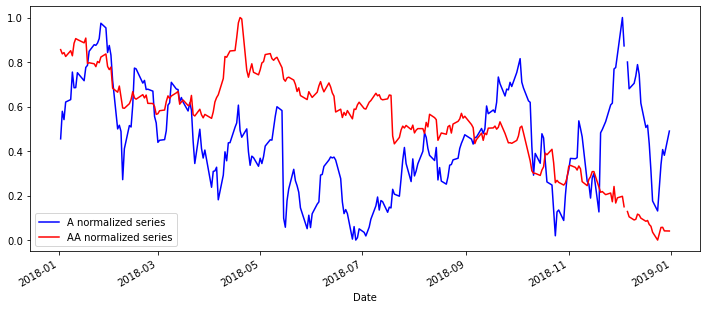

In [6]:
# Plotting the results
plt.figure(figsize=(12,5))

ax1 = A_series_scaled.plot(color='blue', label='A normalized series')
ax2 = AA_series_scaled.plot(color='red', label='AA normalized series')

plt.legend()
plt.show()

In [7]:
# Looking at top closest pairs 
pairs

[('AEP', 'DUK'),
 ('AEE', 'CMS'),
 ('AIG', 'HIG'),
 ('AIV', 'AVB'),
 ('CMS', 'ETR'),
 ('AVB', 'EQR'),
 ('CMS', 'DTE'),
 ('BAC', 'C'),
 ('AIV', 'EQR'),
 ('AEE', 'EXC'),
 ('COF', 'FDX'),
 ('CMS', 'EXC'),
 ('AES', 'EXC'),
 ('CMG', 'CTXS'),
 ('AA', 'HAL'),
 ('FDX', 'FHN'),
 ('C', 'COF'),
 ('AEE', 'DTE'),
 ('BAC', 'COF'),
 ('AEE', 'AIV')]

These pairs will be used during the trading signal generation stage.

In [8]:
# Looking at historical standard deviations of pair portfolios
historical_std

{('AEP', 'DUK'): 0.03267876772027142,
 ('AEE', 'CMS'): 0.0416011945152039,
 ('AIG', 'HIG'): 0.0652885492968876,
 ('AIV', 'AVB'): 0.05569814286963368,
 ('CMS', 'ETR'): 0.06756191832822638,
 ('AVB', 'EQR'): 0.07095824200491643,
 ('CMS', 'DTE'): 0.07129416137751295,
 ('BAC', 'C'): 0.07238400101802571,
 ('AIV', 'EQR'): 0.06232467824817034,
 ('AEE', 'EXC'): 0.05886863881529773,
 ('COF', 'FDX'): 0.07775444141564748,
 ('CMS', 'EXC'): 0.06999879393225204,
 ('AES', 'EXC'): 0.07644684425374418,
 ('CMG', 'CTXS'): 0.07685408535431078,
 ('AA', 'HAL'): 0.07276640718266539,
 ('FDX', 'FHN'): 0.0818846661974872,
 ('C', 'COF'): 0.07957419899507578,
 ('AEE', 'DTE'): 0.0777236236396527,
 ('BAC', 'COF'): 0.08521672440591707,
 ('AEE', 'AIV'): 0.08570715492924419}

Generally, we can observe that with the increase of Euclidean distance between pairs the volatility is also rising.

### Generating trading signals

Now let's generate trading signals for the testing dataset.

In [9]:
# Performing the signal generation stage using (2 * st. variation) as a threshold
strategy.trade_pairs(test_data, divergence=2)

# Getting series of portfolio values, trading signals, and normalized price series of elements for each chosen pair
portfolio_series = strategy.get_portfolios()
trading_signals = strategy.get_signals()
normalized_prices = strategy.normalized_data

In [10]:
# Looking at calculated portfolio value series
portfolio_series.head()

,"('AEP', 'DUK')","('AEE', 'CMS')","('AIG', 'HIG')","('AIV', 'AVB')","('CMS', 'ETR')","('AVB', 'EQR')","('CMS', 'DTE')","('BAC', 'C')","('AIV', 'EQR')","('AEE', 'EXC')","('COF', 'FDX')","('CMS', 'EXC')","('AES', 'EXC')","('CMG', 'CTXS')","('AA', 'HAL')","('FDX', 'FHN')","('C', 'COF')","('AEE', 'DTE')","('BAC', 'COF')","('AEE', 'AIV')"
2019-01-02,-0.092994,0.042667,-0.041827,0.030068,-0.087194,-0.058393,0.018991,0.084558,-0.028325,-0.111894,0.107363,-0.154561,-0.049503,0.096879,-0.040072,-0.038377,-0.048860,0.061658,0.035698,0.117807
2019-01-03,-0.100628,0.043968,-0.039424,0.045782,-0.088448,-0.060528,0.009027,0.076408,-0.014746,-0.107735,0.124658,-0.151703,-0.055184,0.131977,-0.034473,-0.091501,-0.048994,0.052995,0.027413,0.091002
2019-01-04,-0.099114,0.055623,-0.062955,0.030997,-0.084121,-0.052998,-0.018262,0.093873,-0.022001,-0.102177,0.165772,-0.157801,-0.020621,0.124842,-0.017099,-0.085405,-0.062695,0.037361,0.031178,0.123127
2019-01-07,-0.103396,0.036794,-0.044899,0.045435,-0.084117,-0.093567,-0.023632,0.075294,-0.048132,-0.146795,0.159695,-0.183589,-0.015925,0.220892,-0.027993,-0.085633,-0.059478,0.013161,0.015816,0.082192
2019-01-08,-0.107733,0.032535,-0.004257,0.071665,-0.100123,-0.073503,-0.003807,0.075265,-0.001838,-0.151069,0.158461,-0.183604,-0.017694,0.238549,-0.045355,-0.096252,-0.065843,0.028728,0.009422,0.022433


In [11]:
# Looking at generated trading signals - target quantities of portfolios to hold
trading_signals.head()

,"('AEP', 'DUK')","('AEE', 'CMS')","('AIG', 'HIG')","('AIV', 'AVB')","('CMS', 'ETR')","('AVB', 'EQR')","('CMS', 'DTE')","('BAC', 'C')","('AIV', 'EQR')","('AEE', 'EXC')","('COF', 'FDX')","('CMS', 'EXC')","('AES', 'EXC')","('CMG', 'CTXS')","('AA', 'HAL')","('FDX', 'FHN')","('C', 'COF')","('AEE', 'DTE')","('BAC', 'COF')","('AEE', 'AIV')"
2019-01-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Also normalized price series for each asset
normalized_prices.head()

,A,AA,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,...,KMX,KO,MMM,MO,RRD,SCHW,STZ,T,XOM,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.361332,0.031072,0.131347,0.112071,0.745579,0.177699,0.479293,0.361133,0.181820,0.537443,...,0.260851,0.648946,0.168152,0.085902,0.117688,0.159507,0.094753,0.215790,0.206716,0.109035
2019-01-03,0.185614,0.031072,-0.054955,0.079270,0.570631,0.054440,0.388588,0.141069,0.167741,0.449924,...,0.215776,0.619607,0.070097,0.072649,0.076044,0.118313,0.062144,0.219749,0.153802,0.109632
2019-01-04,0.344632,0.090935,0.016936,0.105085,0.671440,0.190025,0.495859,0.224176,0.241268,0.561940,...,0.287563,0.713694,0.173198,0.134498,0.126741,0.200701,0.129233,0.294979,0.278919,0.142482
2019-01-07,0.445560,0.093216,0.013028,0.121182,0.725844,0.202608,0.527252,0.246225,0.257693,0.546128,...,0.405259,0.650969,0.167197,0.059886,0.152089,0.215071,0.176007,0.349421,0.297216,0.163386
2019-01-08,0.516719,0.088369,0.046427,0.145480,0.681574,0.294539,0.562225,0.332300,0.318705,0.563275,...,0.341820,0.704589,0.178107,0.073631,0.179248,0.240937,0.205676,0.388026,0.322933,0.155322


The DistanceStrategy class also allows plotting data for a chosen pair. Looking again at the list of chosen pairs to pick a pair to plot.

In [13]:
# Looking at top closest pairs 
pairs

[('AEP', 'DUK'),
 ('AEE', 'CMS'),
 ('AIG', 'HIG'),
 ('AIV', 'AVB'),
 ('CMS', 'ETR'),
 ('AVB', 'EQR'),
 ('CMS', 'DTE'),
 ('BAC', 'C'),
 ('AIV', 'EQR'),
 ('AEE', 'EXC'),
 ('COF', 'FDX'),
 ('CMS', 'EXC'),
 ('AES', 'EXC'),
 ('CMG', 'CTXS'),
 ('AA', 'HAL'),
 ('FDX', 'FHN'),
 ('C', 'COF'),
 ('AEE', 'DTE'),
 ('BAC', 'COF'),
 ('AEE', 'AIV')]

Let's look at normalized prices, portfolio values and generated trading signals for the pair ('BAC', 'C') - with number 7 (counting from zero).

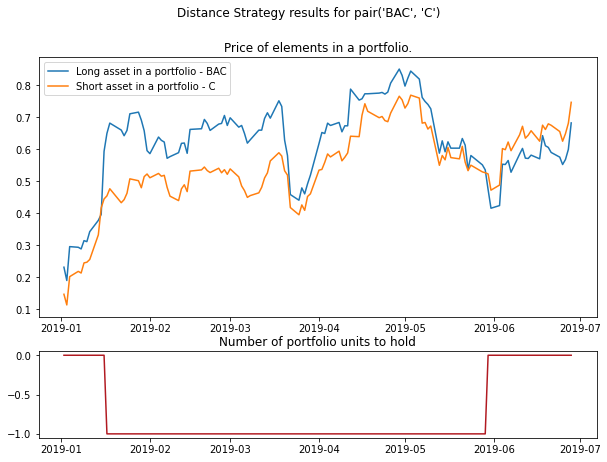

In [14]:
# Plotting normalized price series of elements in a pair
figure_pair = strategy.plot_pair(7)

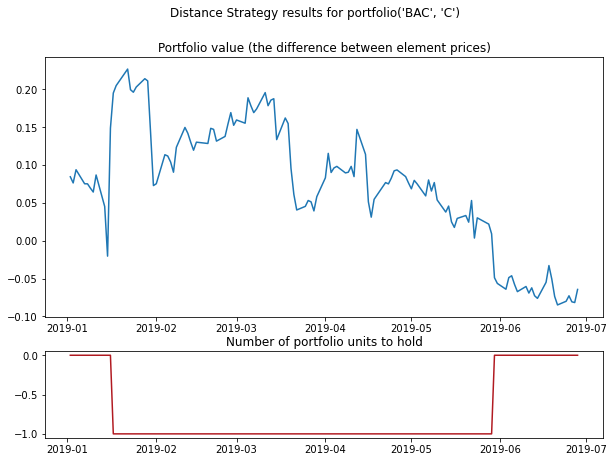

In [15]:
# Plotting portfolio value series
figure_portfolio = strategy.plot_portfolio(7)

This pair of stocks is moving similarly over the testing period. A signal to open a sell position on a portfolio is generated in the middle of January 2019 and a signal to close this position is generated around the end of May 2019.

As the long asset in a portfolio is 'BAC' and the short asset is 'C', the signal to sell a portfolio means we should sell 'BAC' and buy 'C'.

We can either buy and sell one share for each asset in a pair or calculate weights for 'BAC' and 'C' based on starting prices and scaling parameters.

First, we should scale by starting prices of each stock and next by scaling parameters ($max(P) - min(P)$) (returns are proportional to initial prices of stocks and negatively proportional to the scaling parameter):

- $Scale_{1} = \frac{P_{1}^{0}}{P_{1}^{0} + P_{2}^{0}} * \frac{(max(P_{2}) - min(P_{2})}{(max(P_{1}) - min(P_{1})) + (max(P_{2}) - min(P_{2}))}$

- $Scale_{2} = \frac{P_{2}^{0}}{P_{1}^{0} + P_{2}^{0}} * \frac{(max(P_{1}) - min(P_{1})}{(max(P_{1}) - min(P_{1})) + (max(P_{2}) - min(P_{2}))}$


In [16]:
# Looking at the scaling parameters (min and max values) used for elements in a portfolio
pair_scales = scaling_parameters.loc[['BAC', 'C']]

pair_scales

,min_value,max_value
BAC,21.778822,31.013632
C,46.040367,73.223732


In [17]:
# So the scaling parameters for 'BAC' and 'C' are
maxmin_BAC = pair_scales.loc['BAC'][1] - pair_scales.loc['BAC'][0]
maxmin_C = pair_scales.loc['C'][1] - pair_scales.loc['C'][0]

scale_BAC = (test_data['BAC'][0] / (test_data['BAC'][0] + test_data['C'][0])) * (maxmin_C / (maxmin_BAC + maxmin_C))
scale_C = (test_data['C'][0] / (test_data['BAC'][0] + test_data['C'][0])) * (maxmin_BAC / (maxmin_BAC + maxmin_C))

print('Scaling parameter for BAC is ', scale_BAC)
print('Scaling parameter for C is ', scale_C)

Scaling parameter for BAC is  0.24140445877630293
Scaling parameter for C is  0.1715663474918053


Now, let's check how much profit would this distance strategy generate on a given (BAC', 'C') pair.

In [18]:
# Returns of elemrnts in a test dataset
test_data_returns = (test_data / test_data.shift(1) - 1)[1:]

test_data_returns.head()

,A,AA,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,...,KMX,KO,MMM,MO,RRD,SCHW,STZ,T,XOM,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.036840,0.000000,-0.099607,-0.014506,-0.047194,-0.034142,-0.039498,-0.060405,-0.004396,-0.030198,...,-0.017151,-0.006180,-0.037654,-0.005476,-0.053864,-0.020683,-0.014874,0.001354,-0.015354,0.000528
2019-01-04,0.034614,0.080031,0.042689,0.011585,0.028541,0.038884,0.048632,0.024278,0.023056,0.039854,...,0.027791,0.019940,0.041141,0.025693,0.069307,0.042240,0.031064,0.025693,0.036869,0.029016
2019-01-07,0.021234,0.002823,-0.002226,0.007141,0.014976,0.003474,0.013573,0.006288,0.005034,-0.005410,...,0.044333,-0.013033,-0.002300,-0.030219,0.032407,0.007069,0.021006,0.018128,0.005200,0.017944
2019-01-08,0.014660,-0.005982,0.019063,0.010702,-0.012006,0.025290,0.014918,0.024396,0.018607,0.005899,...,-0.022881,0.011289,0.004191,0.005740,0.033632,0.012635,0.013050,0.012626,0.007271,-0.006800
2019-01-09,0.020935,0.030089,0.016982,0.010192,0.016691,0.005030,0.011819,0.025340,0.008665,0.000914,...,0.011246,-0.019166,0.003235,0.012230,0.086768,0.012708,-0.124173,-0.021775,0.005275,0.005325


For unscaled portfolio we'll invest 50% into the 'BAC' asset and 50% in the 'C' asset. 

For scaled portfolio we should calculate the weights - make scales for 'BAC' and 'C' sum up to 1.

In [19]:
weight_BAC = scale_BAC / (scale_BAC + scale_C)
weight_C = 1 - weight_BAC

print("For scaled portfolio we'll invest ", round(weight_BAC, 3), "% into the BAC asset.")
print("And ", round(weight_C, 3), "% into the C asset.")

For scaled portfolio we'll invest  0.585 % into the BAC asset.
And  0.415 % into the C asset.


Let's test that weight parameters are calculated right

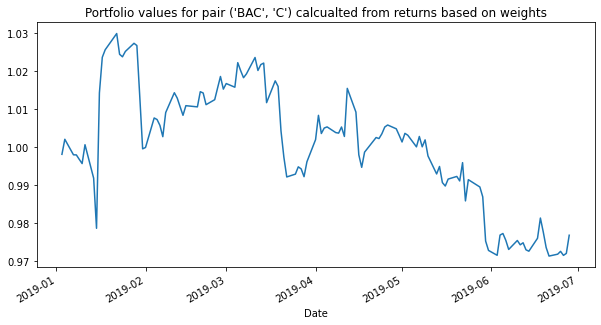

In [20]:
# Pair portfolio price from returns using weight parameters
pair_portfolio_returns = test_data_returns['BAC'] * weight_BAC - test_data_returns['C'] * weight_C
pair_portfolio_price = (pair_portfolio_returns + 1).cumprod()
pair_portfolio_price.plot(title="Portfolio values for pair ('BAC', 'C') calcualted from returns based on weights", figsize=(10,5));

As we can see, this price performance matches the pair portfolio price performance from the DistanceStrategy class plot_portfolio() function. 

In [21]:
# Invested portfolio prices for scaled and unscaled weights
portfolio_returns_unscaled = test_data_returns['BAC'] * 0.5 - test_data_returns['C'] * 0.5
portfolio_returns_unscaled = portfolio_returns_unscaled * (trading_signals["('BAC', 'C')"].shift(1))
portfolio_price_unscaled = (portfolio_returns_unscaled + 1).cumprod()

portfolio_returns_scaled = test_data_returns['BAC'] * weight_BAC - test_data_returns['C'] * weight_C
portfolio_returns_scaled = portfolio_returns_scaled * (trading_signals["('BAC', 'C')"].shift(1))
portfolio_price_scaled = (portfolio_returns_scaled + 1).cumprod()

Investment portfolio value rose to  1.046562594573207


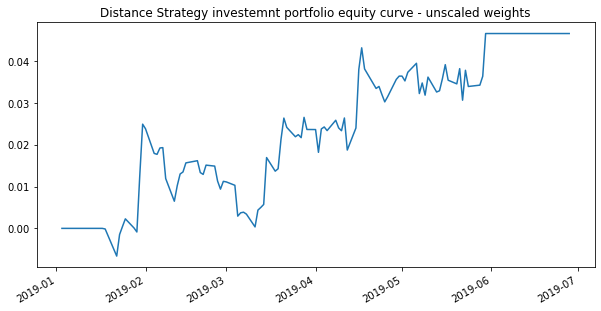

In [22]:
# Equity curve of our unscaled portfolio price
equity_curve_unscaled = portfolio_price_unscaled - 1

equity_curve_unscaled.plot(title='Distance Strategy investemnt portfolio equity curve - unscaled weights', figsize=(10,5));
print('Investment portfolio value rose to ', portfolio_price_unscaled[-1])

Investment portfolio value rose to  1.0474529679420679


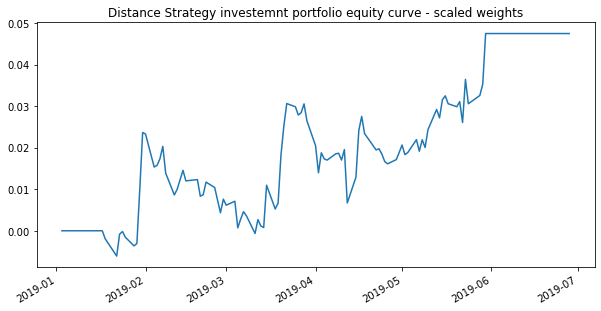

In [23]:
# Equity curve of our scaled portfolio price
equity_curve_scaled = portfolio_price_scaled - 1

equity_curve_scaled.plot(title='Distance Strategy investemnt portfolio equity curve - scaled weights', figsize=(10,5));
print('Investment portfolio value rose to ', portfolio_price_scaled[-1])

So using trading signals from the Distance Strategy for this particular example resulted in the equity curve of our investment portfolio increasing from 1 in mid-January 2019 to around 1.0475 in late May 2019 for the scaled portfolio and 1.0466 for the unscaled one.

## Conclusion

This notebook describes the Distance Strategy class and its functionality. Also, it shows how the stages of the method (pairs formation and trading signals generation) can be used on real data and that this method can output profitable trading signals.

The algorithms and the descriptions used in this notebook were described by _Gatev, E., Goetzmann, W. N.,_ and _Rouwenhorst, K. G._ in the paper __Pairs Trading: Performance of a Relative Value Arbitrage Rule__  [available here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=141615).

Key takeaways from the notebook:
- The distance approach can be divided into two stages - pairs formation and trading signals generation.
- The distance approach works as follows:
  - First, a historical period is defined, cumulative returns for assets in this period are normalized.
  - Second, using the Euclidean squared distance on the normalized price time series, $n$ closest pairs of assets are picked.
  - During the treading period, the trading signals are generated. The mechanism behind this process is the following:
  - If the difference between the price of elements in a pair diverged by
    more than 2 standard deviations (calculated for each pair during the training period), the positions are
    opened - long for the element with a lower price in a portfolio and short for an element with a higher price
    in a portfolio.
  - These positions are closed when the normalized prices cross or when the trading period ends.
- No cointegration tests are being performed in the distance approach, so dependencies found using this approach can be spurious.